# Analyzing Uncertainty in a Scramjet Model Using Active Subspaces

In this notebook, we'll be summarizing the active subspaces-based uncertainty quantification presented in [Exploiting Active Subspaces to Quantify Uncertainty in the Numerical Simulation of the HyShot II Scramjet](http://arxiv.org/abs/1408.6269).

A scramjet is an engine designed to intake air and combust fuel at supersonic speeds. Because physically prototyping and experimenting is expensive, we must use numerical simulations to explore the behavior of these machines. The simulation we use is based on the HyShot II vehicle and has 7 input parameters:

Parameter | Lower bound | Upper bound
--- | --- | --- 
Angle of attack | 2.6 | 4.6 
Turbulence intensity | 0.1 | 1.9 
Turbulence length scale | 122.5 | 367.5 
Stagnation pressure | 1.6448e7 | 1.9012e7 
Stagnation enthalpy | 3.0551e6 | 3.4280e6 
Cowl transition location | 0.03 | 0.07 
Ramp transition location | 0.087 | 0.203 

These parameters are used in our complex multiphysics simulation modelling the fluid flow in the scramjet. From our simulation, we compute our quantity of interest, a normalized integral of pressure over the end of the engine:
$$
\frac{1}{vol(V)}\iiint\limits_VP\ dx\ dy\ dz
$$
where V is a 3D region at the end of the scramjet and vol(V) is the volume of this region. This quantity can be used as a metric for judging performance and determining whether _unstart_ has occured (unstart is a catastrophic failure resulting in loss of thrust). For each combination of parameters used in our simulation, we compute this quantity for fuel-air equivalence ratios of .30 and .35.

We'll use the notation $f(\mathbf{x})$ to denote the quantity of interest as a function of normalized input parameters ($\mathbf x$). For the purposes of uncertainty quantification, we'd like to estimate bounds of $f$, identify sets of inputs that result in $f$ remaining below a certain threshold, and estimate a cumulative distribution function of $f$ given a density on $\mathbf x$.

The most straightforward way to achieve our objective would be to exhaustively sample the space of input parameters and use the resulting data to calculate what we want. However, because our input space is high-dimensional and the simulation is very expensive, this is infeasible. To compute what we want, we reduce the dimensionality of the problem by identifying the 'most important' direction in the input space and examining our quantity of interest along this direction. We use an _active subspace_ approach (see [Active Subspace Methods in Theory and Practice: Applications to Kriging Surfaces](http://epubs.siam.org/doi/abs/10.1137/130916138)) based on the matrix
$$
\mathbf C = \int\nabla f(\mathbf x)\nabla f(\mathbf x)^T \rho(\mathbf x)\ d\mathbf x = \mathbf W \Lambda\mathbf W^T
$$
where $\rho$ is a probability density on $\mathbf x$ and $\mathbf W \Lambda\mathbf W^T$ is the eigendecomposition of $\mathbf C$. The active subspace is the space spanned by the first several eigenvectors, and we can use it to construct an approximation of $f$:
$$
f(\mathbf x)\approx g(\mathbf W_1^T\mathbf x)
$$
where $\mathbf W_1$ contains the first $n$ columns of $\mathbf W$ and $g$ is a function from $R^n$ to $R$. Since we don't have access to the gradient of $f$, we use the following least squares-based algorithm to identify the single most important direction in the parameter space:
1. Using $M$ data points, determine the parameters $\hat u_0, \hat u_1,\dots,\hat u_m$ of the linear approximation $f(\mathbf x)\approx \hat u_0 + \hat u_1x_1 + \cdots + \hat u_mx_m$ such that $\hat{\mathbf u} = argmin_{\mathbf u}||\mathbf{Au}-\mathbf f||_2^2$ where
$$
\mathbf A = \left[\begin{matrix}1 & \mathbf x_1^T\\\vdots & \vdots\\ 1 & \mathbf x_M^T\end{matrix}\right],\ \mathbf f = \left[\begin{matrix}f_1\\\vdots\\f_M\end{matrix}\right],\ \hat{\mathbf u} = \left[\begin{matrix}\hat u_0\\\vdots\\\hat u_m\end{matrix}\right]
$$
2. Compute $\mathbf w = \hat{\mathbf u}'/||\hat{\mathbf u}'||$ where $\hat{\mathbf u}' = [\hat u_1, \cdots, \hat u_m]^T$. $\mathbf w$ is the vector pointing in the most important direction in the parameter space.

To examine the effects of variability in $\mathbf w$, we use a bootstrap algorithm:
1. Choose the number $N$ of bootstrap replicates
2. For $k$ from 1 to $N$:
    1. Let $\boldsymbol{\pi}^k = [\pi_1^k,\cdots,\pi_M^k]$ be integers from 1 to $M$ sampled uniformly with replacement.
    2. Let $\mathbf f^k$ be the vector whose $i^{th}$ element is $f_{\pi^k}$ and $\mathbf A^k$ be the matrix whose $i^{th}$ row is $[1,\ \mathbf x_{\pi^k}^T]$.
    3. Compute $\mathbf w^k$ using $\mathbf A = \mathbf A^k$ and $\mathbf f = \mathbf f^k$ as above.

We'll now code up the analysis using the [Python Active-subspaces Utility Library](https://github.com/paulcon/active_subspaces)

In [1]:
%matplotlib inline
import numpy as np
import pandas as pn
import active_subspaces as ac
import matplotlib.pyplot as plt

First we import the data and separate inputs (X) from outputs (F)

In [2]:
df = pn.DataFrame.from_csv('HyShotII35.txt')
data = df.as_matrix()
X = data[:,0:7]
F = data[:,7:9]
labels = df.keys()
in_labels = labels[:7]
out_labels = labels[7:9]

#The data for equivalence ratio .30 is already normalized
df30 = pn.DataFrame.from_csv('HyShotII30.txt',header=None,index_col=None)
data = df30.as_matrix()
XX30 = data[:,0:7]
F30 = data[:,7]

Now we normalize each of the input parameters to the interval [-1, 1] and separate our outputs

In [3]:
#normalize the ratio = .35 data
xl = np.array([2.6,0.1,122.5,1.6448e7,3.0551e6,0.6*0.05,0.6*0.145])
xu = np.array([4.6,1.9,367.5,1.9012e7,3.4280e6,1.4*0.05,1.4*0.145])
XX = ac.utils.misc.BoundedNormalizer(xl,xu).normalize(X)

f30 = F30[:]
out_label30 = out_labels[0]
f35 = F[:,1]
out_label35 = out_labels[1]

Set up our subspaces

In [4]:
ss30 = ac.subspaces.Subspaces()
ss35 = ac.subspaces.Subspaces()
#Compute OLS subspaces
ss30.compute(X=XX30,f=f30[:,np.newaxis],sstype=5,nboot=500)
ss35.compute(X=XX,f=f35[:,np.newaxis],sstype=5,nboot=500)

Plot the quantity of interest against $\mathbf w^T\mathbf x$ for each equivalence ratio

/home/ryhoward/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


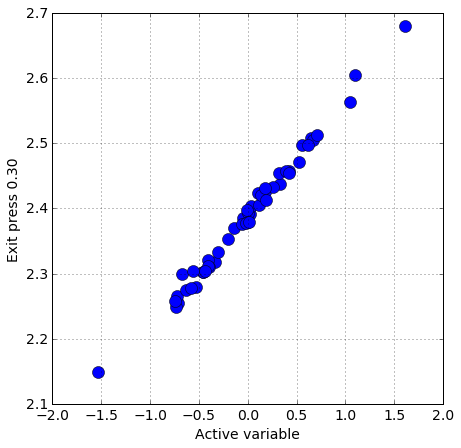

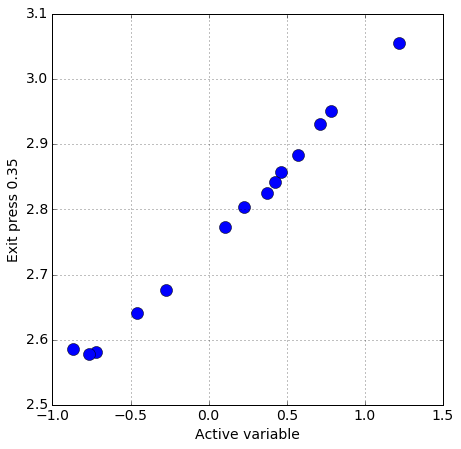

In [5]:
#active variable values associated with XX, XX30
y30 = np.dot(XX30,ss30.W1)
y35 = np.dot(XX,ss35.W1)
#plots of response (pressure) vs. active variable
ac.utils.plotters.sufficient_summary(y30,f30,out_label30)
ac.utils.plotters.sufficient_summary(y35,f35,out_label35)

We can see a very tight, linear, univariate trend in each case; we can use this low-dimensional structure to perform our uncertainty quantification.

In [6]:
#Display the components of w
print "For ratio .30, the components of w are:"
print np.hstack((ss30.W1,in_labels[:,np.newaxis]))
print "\nFor ratio .35, the components of w are:"
print np.hstack((ss35.W1,in_labels[:,np.newaxis]))

For ratio .30, the components of w are:
[[0.6506291125237785 'AoA']
 [0.5564882394415736 'Turb int']
 [-0.00019385917136808414 'Turb len']
 [0.3685178706576434 'Stag pres']
 [-0.35655202902054633 'Stag enth']
 [-0.019646812925308874 'Cowl trans']
 [0.06067777243378229 'Ramp trans']]

For ratio .35, the components of w are:
[[0.6996096399487891 'AoA']
 [0.48232002463866075 'Turb int']
 [-0.027026255920049064 'Turb len']
 [0.1996834930835886 'Stag pres']
 [-0.47384190914453245 'Stag enth']
 [-0.06019930117673946 'Cowl trans']
 [0.09570642026669228 'Ramp trans']]


The components of $\mathbf w$ tell us how sensitive the quantity of interest is to each parameter. From the above output, we can see that Angle of Attack, Turbulence Intensity, and Stagnation conditions (pressure and enthalpy) dominate the active subspace, and (perhaps by coincidence) the components are roughly the same between the fuel-air equivalence ratios, except for an exchange of weight between stagnation pressure and stagnation enthalpy.

We'll now demonstrate the bootstrap for equivalence ratio .30.

In [7]:
N = int(1e5) #Number of bootstrap replicates
M,m = XX30.shape
w_boot = np.empty(shape=(m,N)) #matrix containing replicates
for k in range(N):
    mask = np.random.randint(0,M,size=(M,))
    f = np.matrix(f30[mask].reshape(M,1))
    A = np.matrix(np.hstack((np.ones((M,1)),XX30[mask])))
    u = (A.T.dot(A)).I.dot(A.T).dot(f)
    w_boot[:,k] = np.squeeze(u[1:])/np.linalg.norm(np.squeeze(u[1:]))
w_br = np.empty(shape=(m,2)) #min-to-max range of bootstrap values
w_br[:,0]=np.squeeze(np.apply_over_axes(np.amin,w_boot,axes=(1)))
w_br[:,1]=np.squeeze(np.apply_over_axes(np.amax,w_boot,axes=(1)))

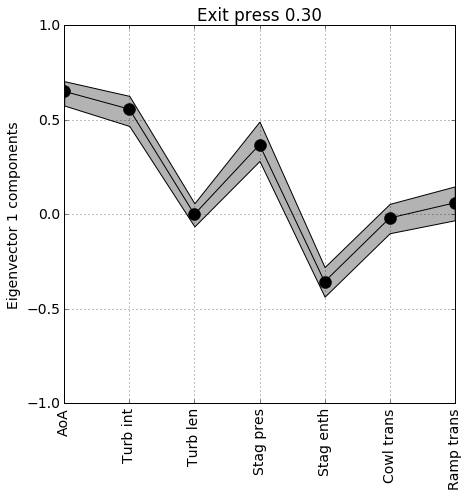

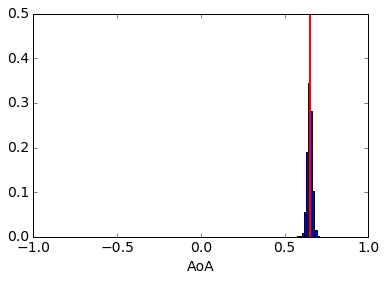

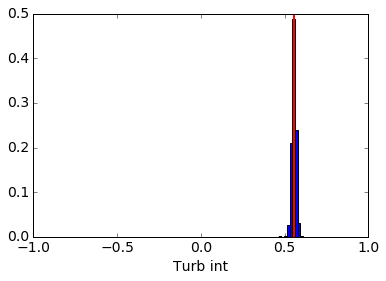

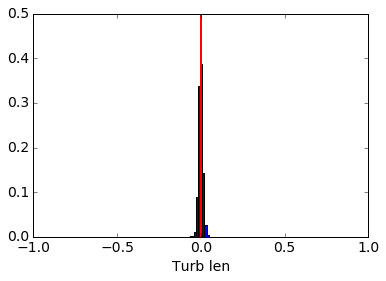

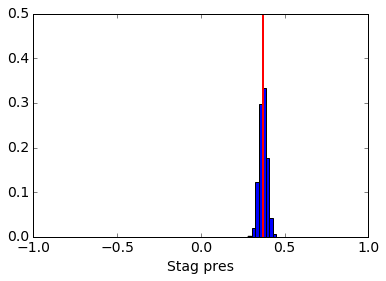

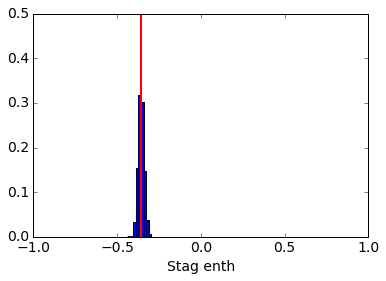

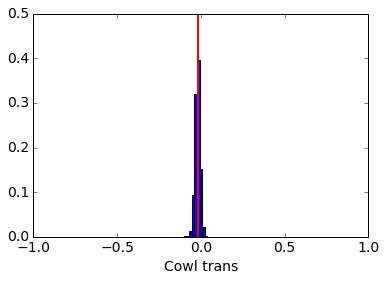

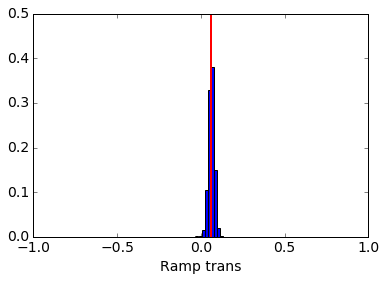

In [8]:
#plot eigenvector components with bootstrap ranges
ac.utils.plotters.eigenvectors(ss30.W1,w_br,in_labels,out_label30)
for k in range(m):#plot histograms
    plt.figure(k)    
    plt.xlabel(in_labels[k])
    plt.xlim([-1,1])
    plt.vlines(ss30.W1[k],0,.5,'r',lw=2)
    plt.hist(w_boot[k,:],bins=10,weights=1.0*np.ones_like(w_boot[k,:])/float(len(w_boot[k,:])))

We can see the historgrams are tightly concentrated around our estimated values (the red vertical lines), indicating that our estimates are close to their true values. Because we have only a few data points for the equivalence ratio of .35, the bootstrap ranges would be much wider in that case, but our confirmation of the results in the .30 case and the similarities between the two cases lead us to be confident for both ratios.

Now that we are confident in our subspace, we can begin the uncertainty quantification (estimating ranges on $f$, identifying safe operating conditions, and estimating a cdf on $f$). Range estimation is sraightforward given the monotonic nature of the subspace: we can maximize $f$ by maximizing the value of our active variable, $\mathbf w^T\mathbf x$, over our input space, and estimate $f$ at this point using a response surface. We do this below.

In [9]:
#Maximizers (and minimizers) of w^T x
xmax30 = np.ones((1,m))*np.sign(ss30.W1).reshape((1,m))
xmin30 = -xmax30
xmax35 = np.ones((1,m))*np.sign(ss35.W1).reshape((1,m))
xmin35 = -xmax35

#Linear response surfaces
surface30 = ac.utils.response_surfaces.PolynomialApproximation(1)
surface35 = ac.utils.response_surfaces.PolynomialApproximation(1)

#Training the surfaces with our data
surface30.train(XX30.dot(ss30.W1),f30[:,None])
surface35.train(XX.dot(ss35.W1),f35[:,None])

#extreme (ex) values of active variable (y) and predicted pressure (f)
yex30 = np.vstack((xmin30,xmax30)).dot(ss30.W1)
fex30 = surface30.predict(yex30)[0]
yex35 = np.vstack((xmin35,xmax35)).dot(ss35.W1)
fex35 = surface35.predict(yex35)[0]

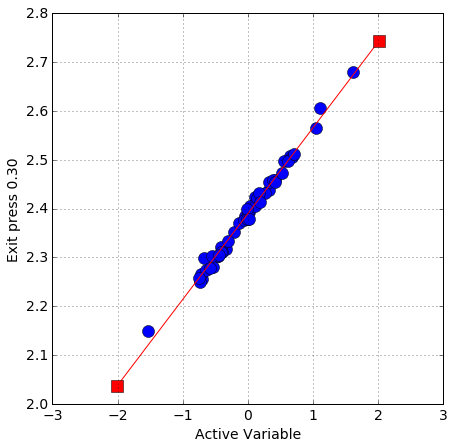

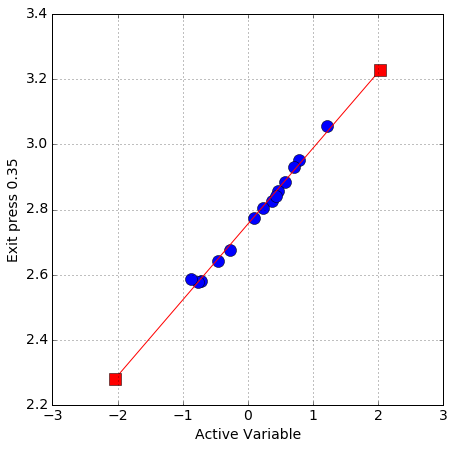

In [10]:
#Plot data (blue dots) with predicted extrema (red squares)
plt.figure(figsize=(7,7))
plt.plot(y30,f30,'bo',yex30,fex30,'rs-',ms=12);plt.grid(True)
plt.xlabel('Active Variable');plt.ylabel(out_label30)
plt.figure(figsize=(7,7))
plt.plot(y35,f35,'bo',yex35,fex35,'rs-',ms=12);plt.grid(True)
plt.xlabel('Active Variable');plt.ylabel(out_label35)

Suppose now that the engine remained safe so long as exit pressure is below 2.8 and becomes unsafe when pressure rises above this. We might reasonably be interested in what regions of our parameter space result in safe operating conditions and which don't. To constrain the exit pressure, we can use our response surface to place a bound on how high the active variable can become before the engine becomes unsafe, and map the save active-variable region to the original parameter space.

Below, we plot our response surfaces and an upper prediction limit that is 2.33 standard errors above our mean response. We also find the active variable value that marks the boundary between safe and unsafe operation. The shaded regions denote safe operation.

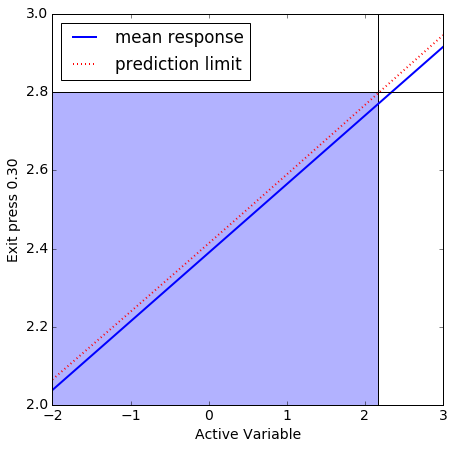

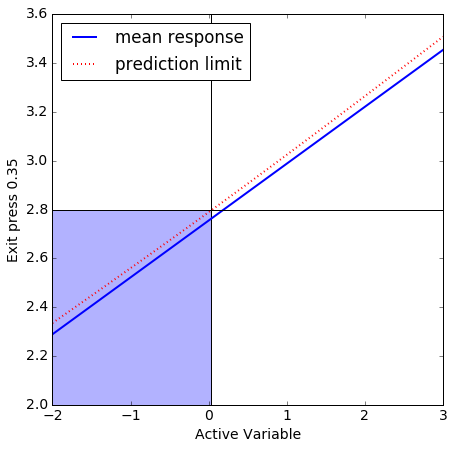

In [11]:
M30 = len(y30); M35 = len(y35)#Number of data points for each ratio

#sums of squares required for somputing standard error
sf30 = np.sqrt(sum((ac.utils.misc.atleast_2d_col(f30)-surface30.predict(y30)[0])**2)/(M30-2))
sy30 = sum((y30-y30.mean())**2)
#predicted response using linear surface + 2.33 std errors
predlim30 = lambda x: surface30.predict(x)[0]+2.33*sf30*np.sqrt(1+1/M30+(x-y30.mean())**2/sy30)

sf35 = np.sqrt(sum((ac.utils.misc.atleast_2d_col(f35)-surface35.predict(y35)[0])**2)/(M35-2))
sy35 = sum((y35-y35.mean())**2)
predlim35 = lambda x: surface35.predict(x)[0]+2.33*sf35*np.sqrt(1+1/M35+(x-y35.mean())**2/sy35)

x = ac.utils.misc.atleast_2d_col(np.linspace(-2,3,200))
#maximum Active variable value s.t. f(x) <= 2.8 according to prediction interval
avmaxval30 = x[np.argmin(abs(predlim30(x)-2.8))]
plt.figure(figsize=(7,7))
plt.plot(x,surface30.predict(x)[0],'b-',x,predlim30(x),'r:',lw=2)
plt.plot(x,2.8*np.ones_like(x),'k-')
plt.vlines(avmaxval30,2,3,'k')
plt.fill_between(x[x<=avmaxval30],2,2.8,alpha=.3)
plt.ylim([2,3])
plt.xlabel('Active Variable');plt.ylabel(out_label30)
plt.legend(['mean response','prediction limit'],loc=2)

avmaxval35 = x[np.argmin(abs(predlim35(x)-2.8))]
plt.figure(figsize=(7,7))
plt.plot(x,surface35.predict(x)[0],'b-',x,predlim35(x),'r:',lw=2)
plt.plot(x,2.8*np.ones_like(x),'k-')
plt.vlines(avmaxval35,2,3.6,'k')
plt.fill_between(x[x<=avmaxval35],2,2.8,alpha=.3)
plt.ylim([2,3.6]);plt.xlim([-2,3])
plt.xlabel('Active Variable');plt.ylabel(out_label35)
plt.legend(['mean response','prediction limit'],loc=2)

The set of normalized parameters resulting in safe operation is $S = \{\mathbf x : \mathbf w^T\mathbf x \leq y_{max},\ -\mathbf 1 \leq \mathbf x\leq \mathbf 1\}$, where $y_{max}$ is the maximum safe active variable value. We will find ranges of input parameters that guarantee safety by finding the largest 'box' that can fit within the set $S$ by solving the optimization problem: maximize$_{\mathbf x}\prod_{i=1}^m|x_i-x_{i,min}|,\ s.t.\ \mathbf x\in S$, where the $x_{i,min}$ are the components of xmin above (the minimizer of the active variable, $\mathbf w^T\mathbf x$).

In [12]:
import scipy.optimize as op

#Functions to minimize
minfun30 = lambda x: -1.0*np.prod(abs(x-xmin30.reshape(x.size)))
minfun35 = lambda x: -1.0*np.prod(abs(x-xmin35.reshape(x.size)))
#constraint functions of the form c(x) >= 0
cfun30 = lambda x: avmaxval30 - sum(ss30.W1*x.reshape(ss30.W1.size))
cfun35 = lambda x: avmaxval35 - sum(ss35.W1*x.reshape(ss35.W1.size))
#constraint dictionaries passed to minimizer
cdict30 = {'type':'ineq','fun':cfun30}
cdict35 = {'type':'ineq','fun':cfun35}

#Normalized parameter values defining the edge of the largest box assuring safe operation
xop30 = op.minimize(minfun30,xmax30,bounds=zip(-1.0*np.ones_like(xl),1.0*np.ones_like(xl)),\
                   constraints=cdict30)
xop35 = op.minimize(minfun35,xmax35,bounds=zip(-1.0*np.ones_like(xl),1.0*np.ones_like(xl)),\
                   constraints=cdict35)
#un-normalizing inputs to original parameter space
xop30 = ac.utils.misc.BoundedNormalizer(xl,xu).unnormalize(xop30.x[None,:]).reshape(m,1)
xop35 = ac.utils.misc.BoundedNormalizer(xl,xu).unnormalize(xop35.x[None,:]).reshape(m,1)
uop30 = ac.utils.misc.BoundedNormalizer(xl,xu).unnormalize(xmin30).reshape(m,1)
uop35 = ac.utils.misc.BoundedNormalizer(xl,xu).unnormalize(xmin35).reshape(m,1)
#sorting bounds for display convenience
A30 = np.sort(np.hstack((uop30,xop30)),axis=1);A35 = np.sort(np.hstack((uop35,xop35)),axis=1)

In [13]:
#Display the safe operating ranges
print "For ratio .30, the ranges providing safe operation are:"
print np.hstack((A30,in_labels[:,None]))
print "\nFor ratio .35, the ranges providing safe operation are:"
print np.hstack((A35,in_labels[:,None]))

For ratio .30, the ranges providing safe operation are:
[[2.6 4.6 'AoA']
 [0.1 1.9 'Turb int']
 [122.5 367.5 'Turb len']
 [16448000.0 19012000.0 'Stag pres']
 [3055100.0 3428000.0 'Stag enth']
 [0.03 0.06999999999999999 'Cowl trans']
 [0.087 0.20299999999999999 'Ramp trans']]

For ratio .35, the ranges providing safe operation are:
[[2.6 3.63839105842259 'AoA']
 [0.1 1.034551952579717 'Turb int']
 [122.50000004083464 367.5 'Turb len']
 [16448000.0 17779217.33689694 'Stag pres']
 [3055100.0000623055 3428000.0 'Stag enth']
 [0.030000000006683934 0.06999999999999999 'Cowl trans']
 [0.087 0.14722668138847395 'Ramp trans']]


Lastly, we can construct a cumulative distribution of $f$ by randomly sampling the (normalized) parameter space, computing the active variable, and computing the response surface value at each point.

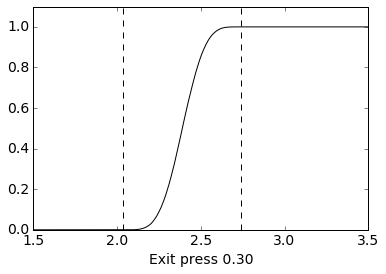

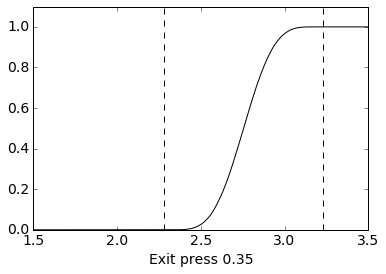

In [14]:
N = int(1e5) #Number of random samples
x = np.random.uniform(-1,1,(N,m))
a30 = x.dot(ss30.W1); a35=x.dot(ss35.W1) #active variable values
s30 = surface30.predict(a30)[0]; s35=surface35.predict(a35)[0] #response surface values
x = np.linspace(1.5,3.5,300)
c30 = np.vectorize(lambda x: sum(s30 <= x)/(1.0*N)) #CDF functions
c35 = np.vectorize(lambda x: sum(s35 <= x)/(1.0*N))
plt.plot(x,c30(x),'k-')
plt.ylim([0,1.1])
plt.xlabel(out_label30)
plt.vlines(fex30,0,1.1,'k','dashed')
plt.figure()
plt.plot(x,c35(x),'k-')
plt.ylim([0,1.1])
plt.xlabel(out_label35)
plt.vlines(fex35,0,1.1,'k','dashed')